In [93]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
# import nltk 

import torch
import re
import pandas as pd
import pickle
import numpy as np
from gensim.models.phrases import Phraser
from torch.utils.data import TensorDataset, DataLoader

In [17]:
!pip install -U nltk

     |████████████████████████████████| 1.5 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 6.0 MB/s eta 0:00:01
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.1
    Uninstalling nltk-3.6.1:
      Successfully uninstalled nltk-3.6.1


In [94]:
import nltk
# from nltk.corpus import stopwords 
# nltk.download('stopwords')

In [95]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [96]:
base_csv = './input/full_train.csv'
df = pd.read_csv(base_csv)
df = df[df.Comment == df.Comment]
df = df[df.Rating == df.Rating]
df.head()

Unnamed: 0    RevId      UserId  \
0          0  3839333  10106093.0   
1          1  2824877    786914.0   
2          2  9816702  22467889.0   
3          3  2684585   1889449.0   
4          4  2737987   8839942.0   

                                             Comment  \
0  Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...   
1  Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...   
2  Thời tiết lạnh như này, cả nhà rủ nhau đến leg...   
3  Em có đọc review thấy mng bảo trà sữa nướng đề...   
4  Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...   

                                          image_urls  Rating  
0  ['https://images.foody.vn/res/g97/966781/s800/...     1.0  
1  ['https://images.foody.vn/res/g69/688413/s800/...     0.0  
2  ['https://images.foody.vn/res/g72/715078/s800/...     1.0  
3  ['https://images.foody.vn/res/g90/895545/s800/...     0.0  
4  ['https://images.foody.vn/res/g4/30186/s800/fo...     1.0

In [97]:
X,y = df['Comment'].values,df['Rating'].values
print(X, y)
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

['Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trông rất thích'
 'Gọi ship 1 xuất cari gà bánh naan và 3 miếng gà nướng(được tặng 1 coca). Đồ ăn khá ngon, tổng 210k được giảm 50k còn 160k. Tuy nhiên gọi 3 miếng gà thì thiếu 1 miếng, mà kể cả đó đủ ba miếng thì khẩu phần vẫn là quá ít so với giá 120k 1 suất.'
 'Thời tiết lạnh như này, cả nhà rủ nhau đến legarden thì hết ý. Nhà mình đã ăn ở đây nhiều rồi rất ưng thái độ phục vụ của các bạn nhân viên, tận tình như người nhà. Đồ ăn thì miễn bàn mình chưa tìm được quán ăn hồng kong nào chuẩn vị như ở đây'
 ...
 'Ngay từ lúc đầu tiên bước vào nhà hàng đã được nhân viên đón tiếp rất nhiệt tình. Rất ấn tượng với cách chăm sóc khách hàng của nhân viên ở đây. Luôn nhiệt tình và ân cần với khách hàng. Nhà hàng cũng được trang trí rất đẹp mắt. Chắc chắn sẽ quay lại. Và sẽ giới thiệu bạn bè tới đây.'
 'Đặt ăn thử mà thấy ngón cá...! 🤩 sẽ còn ủn hộ quán nhìu nhìu.'
 'Nay xem bóng đá VN lười nấu cơm. Nghe các bạn giới thiệu mỳ ý chỗ này siêu ngon, giá 

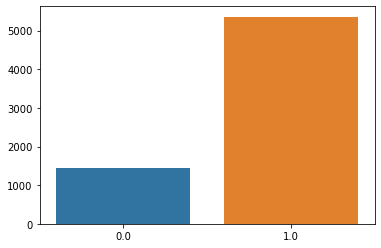

In [98]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array([1.0,0.0]),y=dd.values)
plt.show()

In [99]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

#     stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        sent = preprocess(sent)
        for word in word_tokenize(sent):
#             word = preprocess_string(word)
            if word not in stopword and word != '':
                word_list.append(word)
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[word] for word in word_tokenize(sent) 
                                     if word in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[word] for word in word_tokenize(sent) 
                                    if word in onehot_dict.keys()])
            
    encoded_train = [1.0 if label ==1.0 else 0.0 for label in y_train]  
    encoded_test = [1.0 if label ==1.0 else 0.0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [100]:
import csv
stopword = []
with open('./processors/stopwords_vn_dash.txt', 'r') as fd:
    reader = csv.reader(fd)
    for row in reader:
        stopword.append(row[0])
stopword = set(stopword)
print(stopword)

{'đều_nhau', 'đặt_ra', 'bởi_ai', 'nói_đủ', 'quá', 'thình_lình', 'nếu_thế', 'trả_ngay', 'nhờ', 'lấy_xuống', 'làm_ngay', 'phía_bạn', 'nhà_chung', 'mỗi_một', 'như_nhau', 'ngày_giờ', 'mạnh', 'nhà_tôi', 'cá_nhân', 'chết_tiệt', 'chị_ấy', 'đến_bao_giờ', 'chớ_gì', 'cho_hay', 'làm_gì', 'có_thế', 'khỏi', 'tênh', 'ngồi_bệt', 'vài_nhà', 'tuốt_luốt', 'đã_vậy', 'ra_lời', 'ấy', 'ráo', 'lần_trước', 'chung_nhau', 'để_cho', 'tiện_thể', 'mỗi_ngày', 'chỉ_chính', 'mang_nặng', 'luôn', 'dù_cho', 'tức_thì', 'ra_điều', 'đang', 'gần_bên', 'cả_năm', 'từ', 'tìm_ra', 'thà_là', 'ý_chừng', 'rồi_tay', 'nghe_chừng', 'ơ_kìa', 'như_không', 'bất_kỳ', 'nào_cũng', 'phía_trên', 'trở_thành', 'giờ_lâu', 'nên', 'xem', 'thời_gian', 'cùng', 'quá_đáng', 'ở_như', 'thái_quá', 'duy_chỉ', 'sáng_rõ', 'hiểu', 'thường_thường', 'bài', 'vừa', 'cũng_nên', 'ừ_thì', 'alô', 'mà_cả', 'nói_ý', 'tin_vào', 'quá_bán', 'quá_giờ', 'chứ_còn', 'tăng_thế', 'lúc_đi', 'ăn_chịu', 'số_là', 'theo', 'bấy_lâu', 'ngay_bây_giờ', 'đến_lời', 'đủ_điểm', 'nếu_được'

In [53]:
!pip install underthesea

     |████████████████████████████████| 11.0 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 235 kB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 540 kB 2.5 MB/s eta 0:00:01


In [101]:
from underthesea import word_tokenize

In [102]:
#process materials:
ev_path = "processors/Englishwords.xlsx"
sf_path =  "processors/Shortform.xlsx"
stopwords_vn_path = "processors/stopwords_vn_dash.txt"
englishwords = pd.read_excel(ev_path, index_col= "English")
shortform = pd.read_excel(sf_path, index_col= "Short")

#phraser for word2vec
bigram = Phraser.load("saves/bigram.pkl")

#word2idx
# word2idx = pickle.load(open("saves/word2idx.pickle", "rb"))
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def isNaN(string):
    return string != string
def preprocess(text):  
  try:
    text = re.sub('<[^>]*>', '', text)
    text = deEmojify(text)
  except:
    print("An exception occurred", text)
  

  #thay chữ cái viết hoa thành viết thường
  text = text.lower()

  #xóa dấu ngắt câu, xóa link và các chữ có chứa chữ số
  clean_text = []
  punc_list = r'.,;:?!\|/&@`~()-_@①②③④⑤⑥⑦⑧⑨#$%^*\'\"'
  for w in (text.split()):
    if "http" in w:
      continue
    clean_text.append(w)
  text = ' '.join(clean_text)
  for punc in punc_list:
    text = text.replace(punc, ' ')

  #xóa bỏ các chữ cái lặp liên tiếp nhau (đỉnhhhhhhhhhh, vipppppppppppppppp)
  length = len(text)
  char = 0
  while char <length-1:
    if text[char] == text[char+1]:
      text = text[:char]+text[char+1:]
      #print(text)
      length-=1
      continue
    char+=1  
  numbers = ["không", "một", "hai", "ba", "bốn", "năm", "sáu", "bảy", "tám", "chín"]
  #chuyển đổi các từ tiếng anh và viết tắt thông dụng sang tiếng Việt chuẩn:
  text_split = text.split()
  for i, w in enumerate(text_split):
    if w in englishwords.index:
      text_split[i] = str(englishwords.loc[w, "Vietnamese"])
    if w in shortform.index:
      text_split[i] = str(shortform.loc[w, "Long"])
    if w.isdigit():
      text_split[i] = ' '.join([numbers[int(c)] for c in w]) 
  text = ' '.join(text_split)

  #loại bỏ tất cả các kí tự đặc biệt còn lại
  digits_and_characters = 'aăâbcdđeêfghijklmnoôơpqrstuưvxywzáàảãạắằẳẵặấầẩẫậéèẻẽẹếềểễệíìỉĩịóòỏõọốồổỗộớờởỡợúùủũụứừửữựýỳỷỹỵ0123456789 '
  text = ''.join([i for i in text if i in digits_and_characters])
  return text


In [103]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)
print(x_train)
print('===')
print(y_train)
print('===')
print(x_test)
print('===')
print(y_test)
print('===')

[list([110, 3, 11, 124, 3, 926, 356, 16, 146, 962, 11])
 list([3, 16, 49, 1, 2, 242])
 list([168, 355, 25, 81, 357, 479, 33, 41, 161, 38, 121]) ...
 list([97, 308, 3, 16, 347, 244, 5, 97, 781, 314, 91, 271, 720, 3, 13, 792, 97, 27, 357, 311, 358, 178, 5, 129, 5, 155, 18, 159, 232, 232, 3, 18, 573, 320, 5, 3, 540, 75, 97, 187, 566, 45, 367, 74, 13, 3, 467, 843, 7, 54, 2])
 list([2, 8, 5, 20, 12, 2, 926, 500, 995, 20, 8, 428, 3, 89, 16, 11, 674, 144, 113, 2, 354, 11])
 list([751, 10, 75, 2, 830, 548, 1, 258, 934, 1, 69, 262, 129, 129, 65, 1, 605, 69, 16, 2, 72, 3, 67, 170, 1])]
===
[1. 1. 0. ... 1. 1. 0.]
===
[list([3, 49, 16, 556, 54, 121, 120, 37, 15, 54, 125, 15, 415])
 list([77, 500, 92, 599, 505, 4, 674, 74, 33, 572, 175, 307, 60, 3, 35, 8, 258, 540, 194, 39, 282, 216, 91, 780, 65, 4, 320, 8, 49])
 list([35, 15, 348, 506, 183]) ...
 list([40, 19, 122, 52, 167, 284, 40, 186, 5, 241, 2, 493, 36, 122, 2, 36, 493, 65, 357, 286, 697, 493, 859, 738, 479, 231, 5, 854, 148])
 list([7, 687, 

<ipython-input-99-ab9860af3cdd>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [105]:
print(f'Length of vocabulary is {len(vocab)}')
print(vocab)

Length of vocabulary is 1000
{'không': 1, 'quán': 2, 'ngon': 3, 'khá': 4, 'k': 5, 'hai': 6, 'gọi': 7, 'món': 8, 'đồ': 9, 'đi': 10, 'hơi': 11, 'lắm': 12, 'vị': 13, 'thịt': 14, 'bánh': 15, 'giá': 16, 'nhân viên': 17, 'gà': 18, 'trà': 19, 'thử': 20, 'ổn': 21, 'không gian': 22, 'phục vụ': 23, 'thơm': 24, 'uống': 25, 'cơm': 26, 'chỗ': 27, 'bát': 28, 'bò': 29, 'mấy': 30, 'lẩu': 31, 'đông': 32, 'chất lượng': 33, 'sốt': 34, 'hàng': 35, 'kiểu': 36, 'mua': 37, 'nhiệt tình': 38, 'nướng': 39, 'cốc': 40, 'đẹp': 41, 'suất': 42, 'bún': 43, 'giá cả': 44, 'kem': 45, 'miếng': 46, 'mềm': 47, 'to': 48, 'rẻ': 49, 'đồ uống': 50, 'nói chung': 51, 'đường': 52, 'tầng': 53, 'chủ': 54, 'bàn': 55, 'hôm': 56, 'sạch sẽ': 57, 'giòn': 58, 'sữa': 59, 'tươi': 60, 'đầu': 61, 'rau': 62, 'bốn': 63, 'kèm': 64, 'xong': 65, 'đặc biệt': 66, 'bình thường': 67, 'no': 68, 'mùi': 69, 'siêu': 70, 'hôm nay': 71, 'có thể': 72, 'ship': 73, 'tiền': 74, 'chè': 75, 'đĩa': 76, 'nhà hàng': 77, 'đá': 78, 'chả': 79, 'nha': 80, 'trứng': 81, 

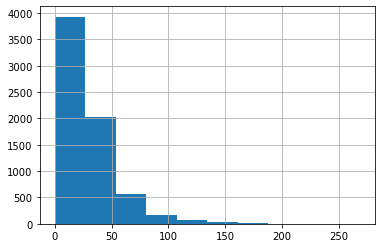

count    6802.000000
mean       28.668774
std        25.063861
min         0.000000
25%        11.000000
50%        22.000000
75%        39.000000
max       268.000000
dtype: float64

In [106]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [107]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [108]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)
print(x_train_pad)
print('===')
print(x_test_pad)

[[  0   0   0 ... 146 962  11]
 [  0   0   0 ...   1   2 242]
 [  0   0   0 ... 161  38 121]
 ...
 [  0   0   0 ...   7  54   2]
 [  0   0   0 ...   2 354  11]
 [  0   0   0 ...  67 170   1]]
===
[[  0   0   0 ... 125  15 415]
 [  0   0   0 ... 320   8  49]
 [  0   0   0 ... 348 506 183]
 ...
 [  0   0   0 ...   5 854 148]
 [  0   0   0 ...  62 687  84]
 [  0   0   0 ... 108 292   3]]


In [109]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
print(train_data)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

from torch.autograd import Variable
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
# for i, (inputs, targets) in enumerate(train_loader):
#     with torch.no_grad():
#         inputs = Variable(inputs)
#         targets = Variable(targets)
#         print("targets.data", targets)
#         print("inputs.data", inputs)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [110]:
# obtain one batch of training data
print(train_loader)
dataiter = iter(train_loader)
print(dataiter)
# sample_x, sample_y = dataiter.next()
sample_x, sample_y = next(dataiter)


print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   5, 660, 500],
        [  0,   0,   0,  ...,   5,  54,   2],
        [  0,   0,   0,  ...,  22, 130,   2],
        ...,
        [  0,   0,   0,  ...,  21, 231, 402],
        [  0,   0,   0,  ..., 368,  32, 225],
        [  0,   0,   0,  ..., 385,  90, 101]])
Sample input: 
 tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       dtype=torch.float64)


In [111]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [112]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
print(vocab_size)
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

1001
SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [113]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [115]:
clip = 6
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        print('jjj===')
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        try:
          output,h = model(inputs,h)
        except:
          continue
        
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        print(accuracy, train_acc)
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    print('aaa')
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            print('ccc')
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            try:
                output, val_h = model(inputs, val_h)
            except:
                continue
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

jjj===
4 4.0
jjj===
41 45.0
jjj===
39 84.0
jjj===
42 126.0
jjj===
39 165.0
jjj===
37 202.0
jjj===
35 237.0
jjj===
35 272.0
jjj===
40 312.0
jjj===
33 345.0
jjj===
30 375.0
jjj===
40 415.0
jjj===
45 460.0
jjj===
41 501.0
jjj===
41 542.0
jjj===
39 581.0
jjj===
41 622.0
jjj===
42 664.0
jjj===
42 706.0
jjj===
42 748.0
jjj===
32 780.0
jjj===
33 813.0
jjj===
39 852.0
jjj===
39 891.0
jjj===
39 930.0
jjj===
44 974.0
jjj===
43 1017.0
jjj===
40 1057.0
jjj===
40 1097.0
jjj===
37 1134.0
jjj===
46 1180.0
jjj===
38 1218.0
jjj===
40 1258.0
jjj===
37 1295.0
jjj===
37 1332.0
jjj===
40 1372.0
jjj===
44 1416.0
jjj===
38 1454.0
jjj===
41 1495.0
jjj===
42 1537.0
jjj===
44 1581.0
jjj===
41 1622.0
jjj===
41 1663.0
jjj===
40 1703.0
jjj===
40 1743.0
jjj===
34 1777.0
jjj===
37 1814.0
jjj===
41 1855.0
jjj===
41 1896.0
jjj===
41 1937.0
jjj===
35 1972.0
jjj===
40 2012.0
jjj===
45 2057.0
jjj===
40 2097.0
jjj===
38 2135.0
jjj===
40 2175.0
jjj===
42 2217.0
jjj===
39 2256.0
jjj===
39 2295.0
jjj===
39 2334.0
jjj===
44 2

45 45.0
jjj===
44 89.0
jjj===
47 136.0
jjj===
46 182.0
jjj===
47 229.0
jjj===
46 275.0
jjj===
45 320.0
jjj===
46 366.0
jjj===
48 414.0
jjj===
46 460.0
jjj===
47 507.0
jjj===
47 554.0
jjj===
43 597.0
jjj===
47 644.0
jjj===
47 691.0
jjj===
44 735.0
jjj===
47 782.0
jjj===
46 828.0
jjj===
45 873.0
jjj===
47 920.0
jjj===
44 964.0
jjj===
43 1007.0
jjj===
45 1052.0
jjj===
44 1096.0
jjj===
44 1140.0
jjj===
42 1182.0
jjj===
45 1227.0
jjj===
43 1270.0
jjj===
45 1315.0
jjj===
46 1361.0
jjj===
47 1408.0
jjj===
45 1453.0
jjj===
48 1501.0
jjj===
45 1546.0
jjj===
43 1589.0
jjj===
49 1638.0
jjj===
48 1686.0
jjj===
45 1731.0
jjj===
45 1776.0
jjj===
44 1820.0
jjj===
49 1869.0
jjj===
48 1917.0
jjj===
41 1958.0
jjj===
41 1999.0
jjj===
47 2046.0
jjj===
46 2092.0
jjj===
45 2137.0
jjj===
44 2181.0
jjj===
42 2223.0
jjj===
44 2267.0
jjj===
46 2313.0
jjj===
47 2360.0
jjj===
46 2406.0
jjj===
44 2450.0
jjj===
44 2494.0
jjj===
44 2538.0
jjj===
41 2579.0
jjj===
45 2624.0
jjj===
45 2669.0
jjj===
46 2715.0
jjj===
47 

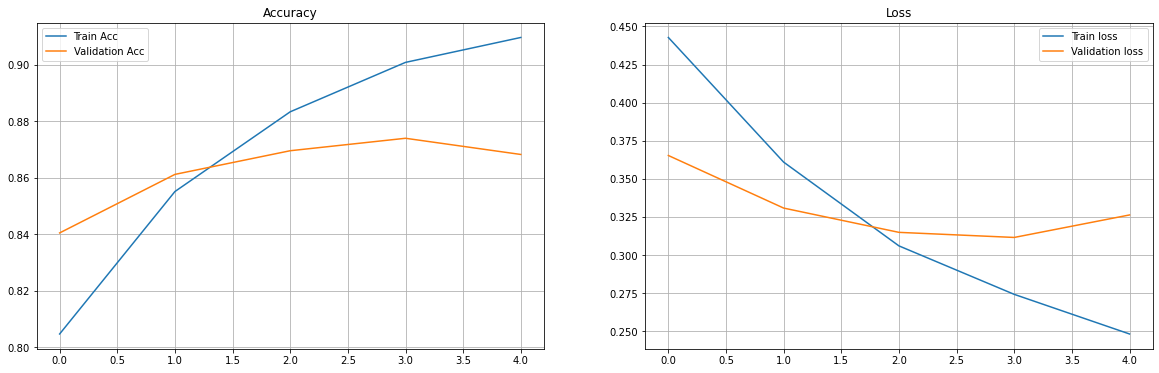

In [116]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [117]:
def predict_text(text):
        text = preprocess(text)
        word_seq = np.array([vocab[word] for word in word_tokenize(text) 
                         if word in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [122]:
index = 644
print(df['Comment'][index])
print('='*70)
print(f'Actual sentiment is  : {df["Rating"][index]}')
print('='*70)
pro = predict_text(df['Comment'][index])
print(pro)
status = 1.0 if pro > 0.6 else 0.0
pro = (1 - pro) if status == 0.0 else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Đặt size l nhg giao size m. Lần trc giao không ống hút, lần đặt trân châu đen giao trân châu trắng
Actual sentiment is  : 0.0
0.05399426072835922
Predicted sentiment is 0.0 with a probability of 0.9460057392716408


In [124]:
test = pd.read_csv("./input/test.csv")
test.insert(2, column = "Rating", value = 0.0) 
for i, item in test.iterrows():
    print(i)
    if isNaN(test['Comment'][i]):
        print(i, '==')
        continue
    pro = predict_text(test['Comment'][i])
    status = 1.0 if pro > 0.6 else 0.0
#     print(test['Comment'][i] , ' -- ', status)
    test['Rating'][i] = status

print(test)
# test.to_csv('result.csv')

0
1
2


<ipython-input-124-57d70017e007>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Rating'][i] = status


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [125]:
import csv
test.to_csv('pre_result.csv')
v = pd.read_csv("./pre_result.csv")
with open("./pre_result.csv", "r") as source:
    reader = csv.reader(source)
      
    with open("result.csv", "w") as result:
        writer = csv.writer(result)
        for r in reader:
            
            # Use CSV Index to remove a column from CSV
            #r[3] = r['RevId']
            writer.writerow((r[2], r[3]))